# Semi-Supervised Approach

- Usage example on different dataset: https://github.com/AndreaBorghesi/anomaly_detection_HPC

In [1]:
import sys

sys.path.insert(0, "../../")  # add query_tool module

from query_tool import M100DataClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

plt.style.use("seaborn-v0_8")

dataset_path = "../../dataset/22-09/year_month=22-09"
client = M100DataClient(dataset_path)

# Available plugins
plugins = list(client.metrics_per_plugin.keys())
print(plugins)

['ipmi', 'ganglia', 'vertiv', 'schneider', 'weather', 'logics', 'nagios', 'slurm', 'job_table']


In [2]:
all_metrics = {plugin: client.metrics_per_plugin[plugin] for plugin in plugins}

# Nodes with the most data available 

In [3]:
# %%script false --no-raise-error

biggest_nodeID = 1162
nodes_rows = pd.DataFrame({"rows": [0] * (biggest_nodeID)}, dtype=int)
fill_na_rows = pd.DataFrame({"node": range(0, biggest_nodeID + 1, 1)}, dtype=int)

for plugin, metrics in all_metrics.items():
    for met in metrics:
        # Create dataset with {nodeID, number of rows of the metric}
        results = (
            client.query(metrics=[met], columns=["node"])
            .groupby("node", observed=False)
            .size()
            .reset_index(name="rows")
            .astype({"node": int})
            .sort_values("node")
            .reset_index(drop=True)
        )
        results = pd.merge(fill_na_rows, results, on="node", how="left")
        nodes_rows["rows"] += results["rows"].fillna(0)

display(
    nodes_rows.sort_values(by="rows", ascending=False)
    .head(10)
    .style.set_caption("Nodes with most data available")
)

# # Results:
# 3	    28246529
# 1	    28246382
# 2	    28243448
# 0	    28219495
# 880	27026042
# 703	27023216
# 334	27020755
# 41	27011895
# 961	27008536
# 585	27003582

,rows
3,28246529.000000
1,28246382.000000
2,28243448.000000
0,28219495.000000
880,27026042.000000
703,27023216.000000
334,27020755.000000
41,27011895.000000
961,27008536.000000
585,27003582.000000


# Nodes with most Nagios anomalies

In [69]:
# %%script false --no-raise-error
results = (
    client.query_plugins(plugins=["nagios"], columns=["node", "value"])
    .query("value in [1,2,3]")
    .groupby("node", observed=False)
    .size()
    .reset_index(name="rows")
    .astype({"node": int})
    .sort_values("node")
    .reset_index(drop=True)
)

results = nodes_rows.iloc[
    results.sort_values(by="rows", ascending=False).iloc[0:10, 0].values, :
]

display(
    results.sort_values(by="rows", ascending=False)
    .head(10)
    .style.set_caption("Nodes with most data available")
)

# Results
# 19	26281005
# 949	25556767
# 298	25544516
# 322	24589350
# 38	24106684
# 335	24094853
# 10	23496599
# 1007	52237
# 1008	10668
# 1002	5334

,rows
19,26281005.000000
949,25556767.000000
298,25544516.000000
322,24589350.000000
38,24106684.000000
335,24094853.000000
10,23496599.000000
1007,52237.000000
1008,10668.000000
1002,5334.000000


In [70]:
node_selected = "949"

# Nagios

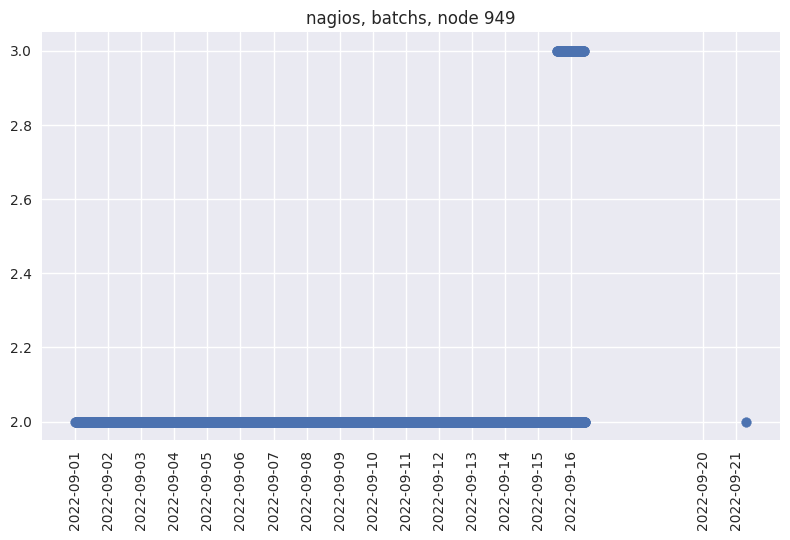

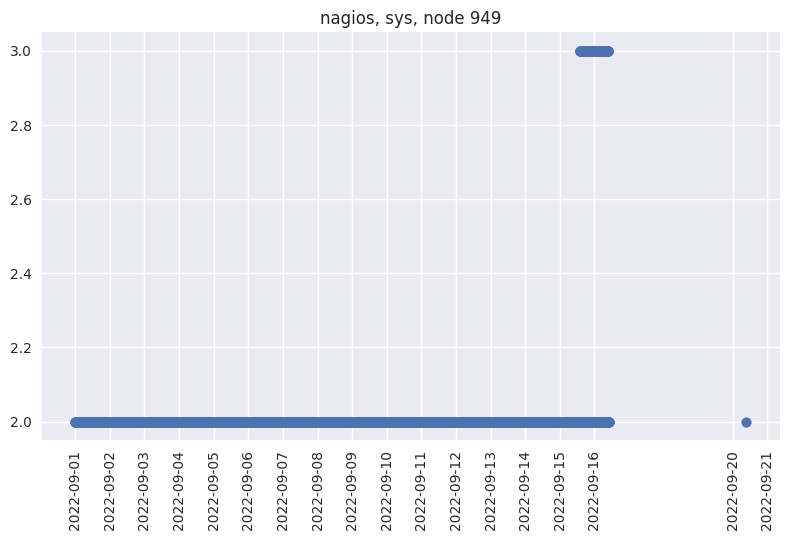

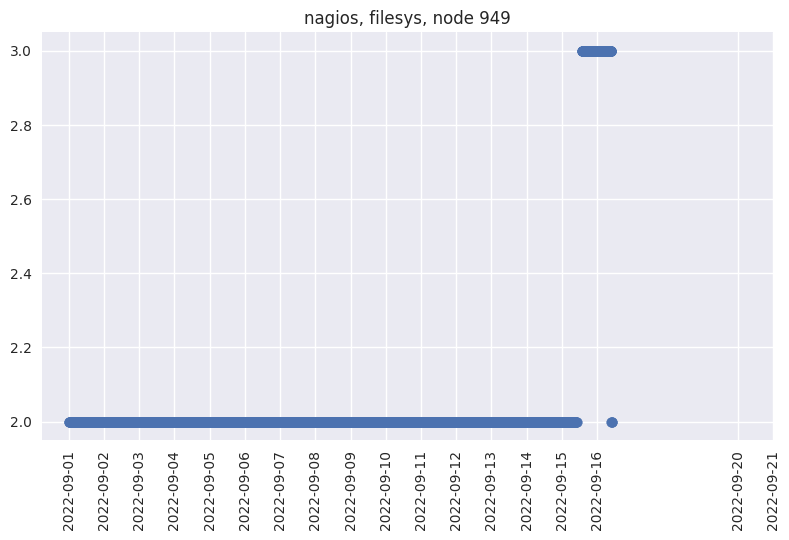

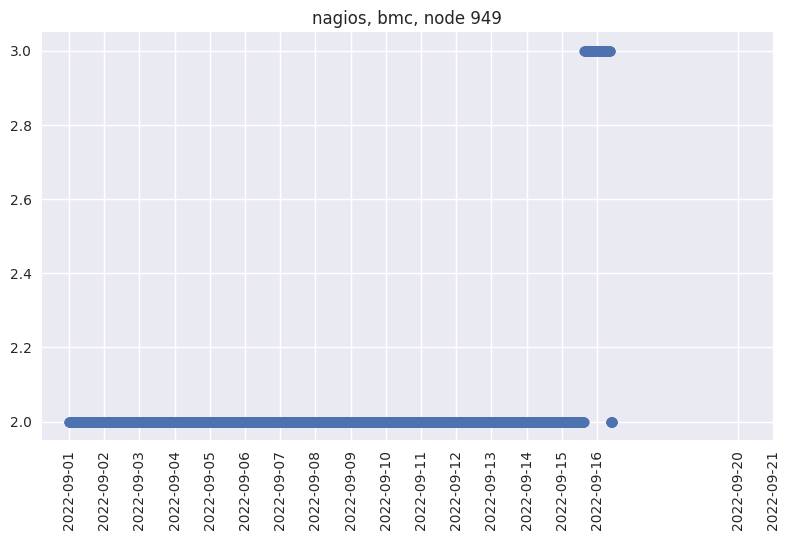

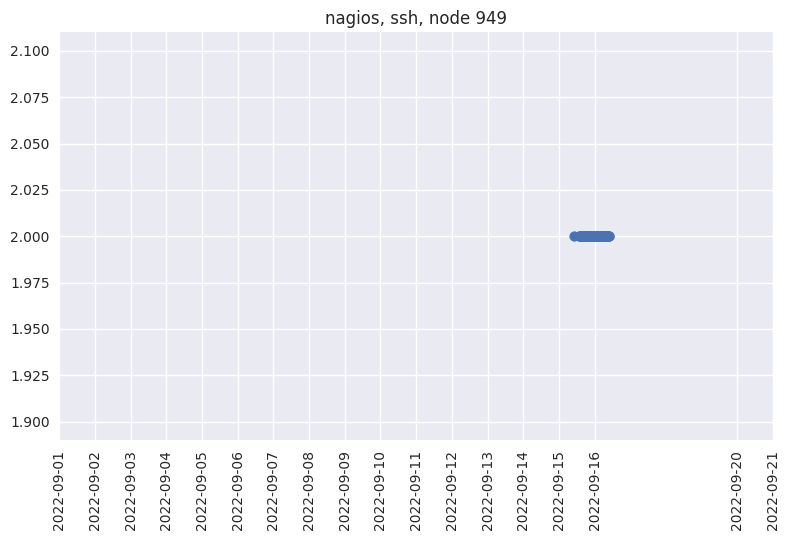

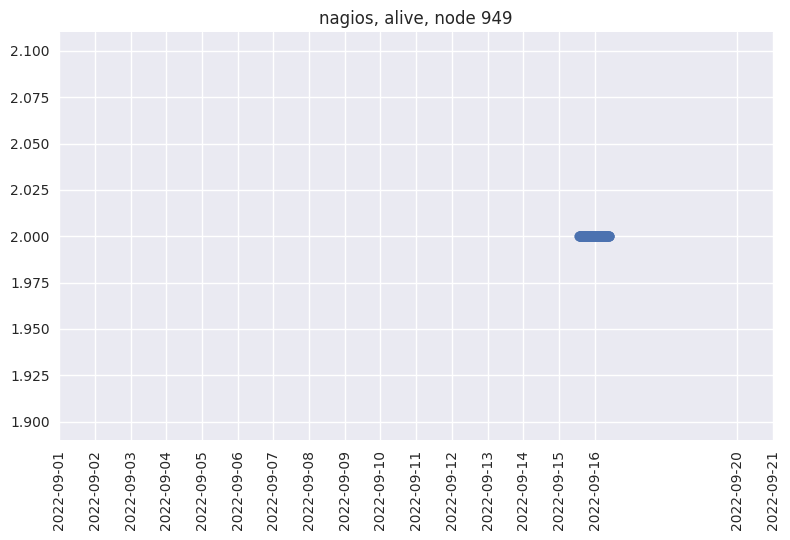

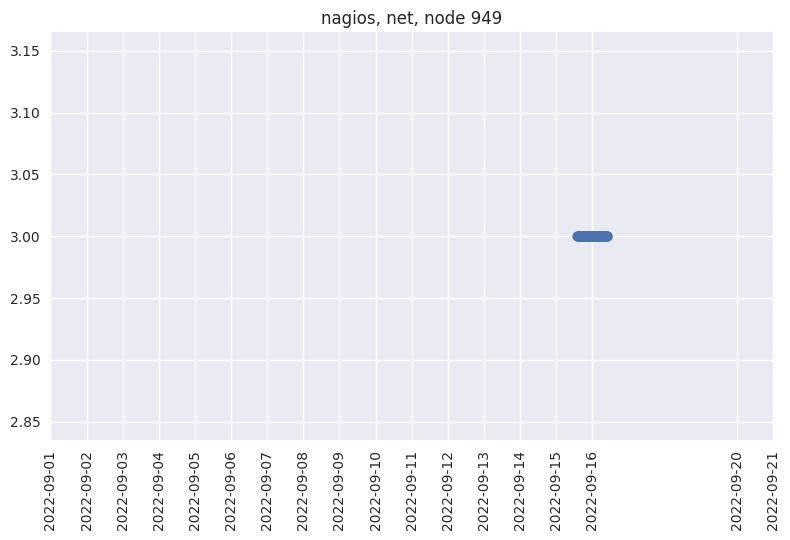

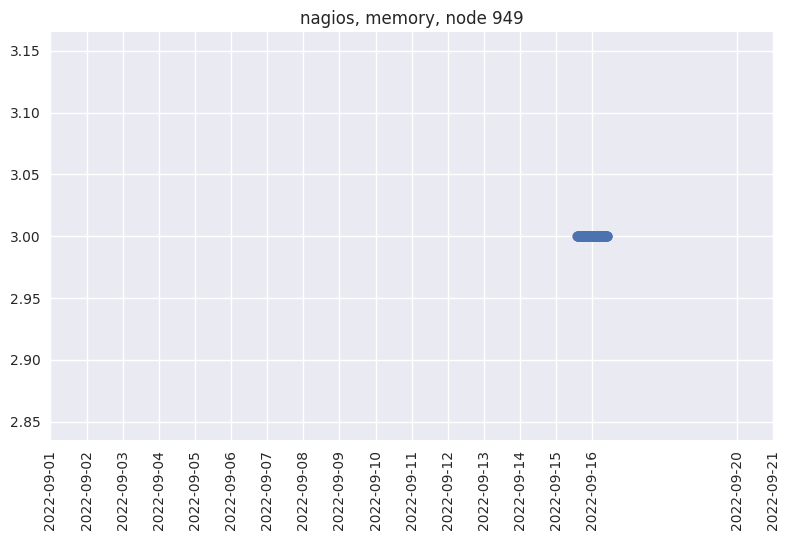

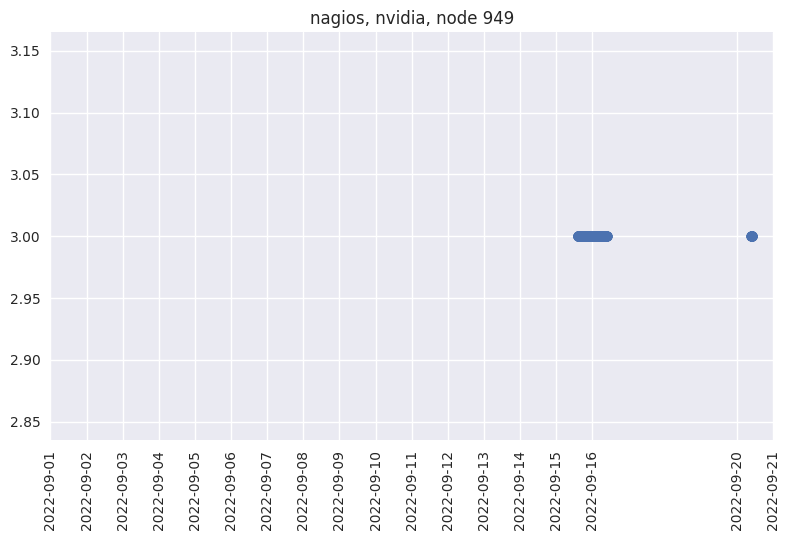

In [71]:
df_nagios = (
    client.query_plugins(plugins="nagios", node=node_selected)
    .sort_values(by="timestamp", ascending=True)
    .query("value in [1,2,3]")
)
df_nagios["tag"] = df_nagios.loc[:, "description"].apply(lambda x: x.split(":")[0])
for tag in df_nagios["tag"].unique():
    df_nagios_plot = df_nagios.loc[df_nagios["tag"] == tag]
    plt.scatter(df_nagios_plot["timestamp"], df_nagios_plot["value"])
    plt.title("{}, {}, node {}".format("nagios", tag, node_selected))
    plt.xticks(rotation="vertical")
    plt.xticks(
        df_nagios["timestamp"]
        .apply(lambda x: datetime.strftime(x, "%Y-%m-%d"))
        .unique()
    )
    plt.tight_layout()
    plt.show()

# Ganglia Metric

In [72]:
df_ganglia = client.query_plugins(plugins="ganglia", node=node_selected)

In [73]:
# Divide into different categories
ganglia_metrics_available = df_ganglia["metric"].unique()
ganglia_metrics_dict = {}

# gpu0
ganglia_metrics_dict["gpu0"] = [
    s for s in ganglia_metrics_available if s.startswith("Gpu0")
]

# gpu1
ganglia_metrics_dict["gpu1"] = [
    s for s in ganglia_metrics_available if s.startswith("Gpu1")
]

# gpu2
ganglia_metrics_dict["gpu2"] = [
    s for s in ganglia_metrics_available if s.startswith("Gpu2")
]

# gpu3
ganglia_metrics_dict["gpu3"] = [
    s for s in ganglia_metrics_available if s.startswith("Gpu3")
]

# system
ganglia_metrics_dict["system"] = [
    s
    for s in ganglia_metrics_available
    if s in ["boottime", "machine_type", "os_name", "os_release"]
]

# network
ganglia_metrics_dict["network"] = [
    s
    for s in ganglia_metrics_available
    if s in ["bytes_in", "bytes_out", "pkts_in", "pkts_out"]
]

# cpu
ganglia_metrics_dict["cpu"] = [
    s for s in ganglia_metrics_available if s.startswith("cpu")
]

# disk
ganglia_metrics_dict["disk"] = [
    s
    for s in ganglia_metrics_available
    if s.startswith("disk") or s in ["part_max_used"]
]

# core
ganglia_metrics_dict["core"] = [s for s in ganglia_metrics_available if s in ["gexec"]]

# load
ganglia_metrics_dict["load"] = [
    s for s in ganglia_metrics_available if s.startswith("load")
]

# memory
ganglia_metrics_dict["memory"] = [
    s for s in ganglia_metrics_available if s.startswith("mem") or s.startswith("swap")
]

# process
ganglia_metrics_dict["memory"] = [
    s for s in ganglia_metrics_available if s.startswith("proc")
]

In [77]:
from datetime import timedelta

for metric_name, val in ganglia_metrics_dict.items():
    for met in val:
        df_metric = df_ganglia.loc[df_ganglia["metric"] == met].sort_values(
            by="timestamp", ascending=True
        )

        # Remove metrics with unmuted values
        if (df_metric["value"] == df_metric["value"].tolist()[0]).all():
            continue

        df_metric["timestamp"] = pd.to_datetime(df_metric["timestamp"])
        df_nagios["timestamp"] = pd.to_datetime(df_nagios["timestamp"])

        df_metric.loc[
            (df_metric["timestamp"] >= (df_nagios["timestamp"] - timedelta(hours=1)))
            or (df_metric["timestamp"] <= (df_nagios["timestamp"] + timedelta(hours=1)))
        ]
        display(df_metric)

        # Scaling for plotting
        df_metric["value"] = MinMaxScaler().fit_transform(
            df_metric["value"].values.reshape(-1, 1)
        )
        plt.scatter(df_metric["timestamp"], df_metric["value"], label=met)
        plt.title("{}, node {}".format(metric_name, node_selected))
        plt.xticks(
            df_metric["timestamp"]
            .apply(lambda x: datetime.strftime(x, "%Y-%m-%d"))
            .unique(),
            rotation="vertical",
        )
        plt.tight_layout()
        plt.legend(loc="upper left")
    plt.show()

ValueError: Can only compare identically-labeled Series objects